1、配置虚拟环境（可选、推荐）<br>
1.1 新建项目文件夹 “boss_spider”，并切换到文件夹<br>
注：后面的路径换成你的实际路径<br>

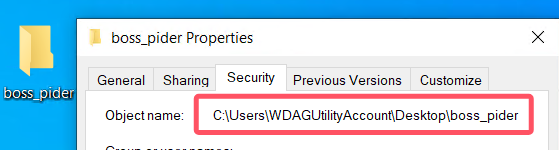
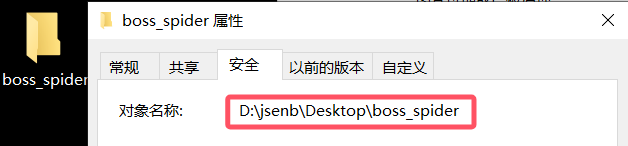

cd C:\Users\WDAGUtilityAccount\Desktop\boss_spider

更正：下面图片打错“boss_spider”

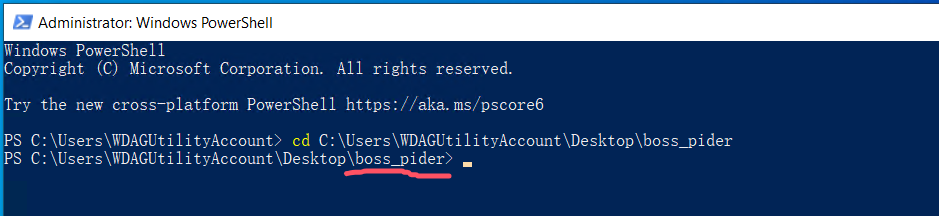
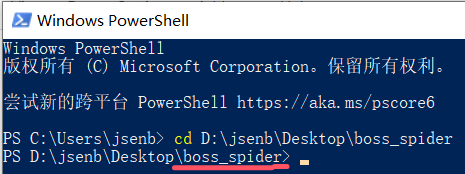

1.2 安装uv<br>
uv是一个使用rust编写的超快速Python包和项目管理工具，文档地址：https://docs.astral.sh/uv/<br>
pip install uv --user

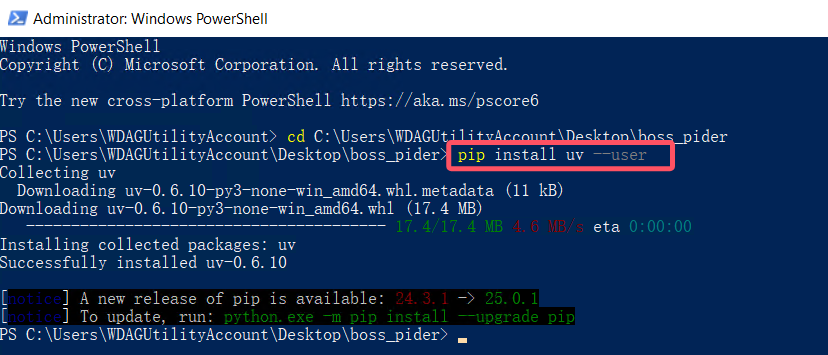

1.3 使用uv创建虚拟环境，并指定python版本<br>
uv venv --python 3.13

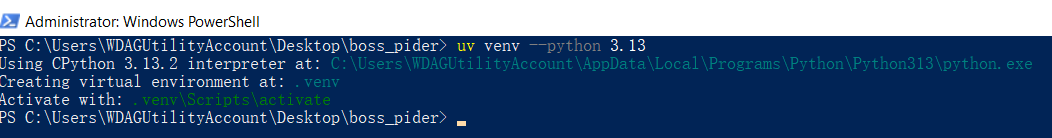

1.4 激活虚拟环境<br>
 .venv\Scripts\activate


1.5 安装依赖<br>
uv pip install requests pandas openpyxl playwright<br>
1.6 安装浏览器驱动<br>
playwright install<br>

2、爬取数据<br>
2.1 如果有网络代理的话，开启全局代理，以免频繁访问被封IP，代理节点可以选择香港。<br>
2.2 不要登陆网站，在未登陆的情况下爬取。<br>
2.3 boss直聘共373个城市，卢淑薇爬取[:100]，韦月爬取[100:200]，梁倚萍爬取[200:300]，沈建爬取[300:]<br>
大家修改一下第88行代码，按照各自分配的任务去爬取数据。<br>
for city in regions[300:]:
2.4 将下面的代码复制到boss_spider.py文件，放入刚刚新建的“boss_spider”文件夹<br>
2.5 爬取数据<br>
python boss_spider.py

In [4]:
import os
import glob
import time
import datetime
from pprint import pprint
import re

import requests
from playwright.sync_api import Playwright, sync_playwright, expect
import pandas as pd



#最大重试次数
MAXTRY = 5

def remove_illegal_chars(value):
    """移除 Excel 不能识别的非法字符"""
    return re.sub(r'[\x00-\x1F]', '', value) if isinstance(value, str) else value

data_dir = os.path.join('.', 'data')  # 使用 os.path.join() 构建路径
os.makedirs(data_dir, exist_ok=True)  # 创建目录

url = "https://www.zhipin.com/wapi/zpCommon/data/cityGroup.json?_=1741943724566"

headers = {
    "accept": "application/json, text/plain, */*",
    "accept-language": "zh-CN,zh;q=0.9,en;q=0.8",
    "cache-control": "no-cache",
    "cookie": "__zp_seo_uuid__=d11ff7c5-e91e-4a53-aca6-e6eaaac3caa4; ab_guid=4631558d-0aa1-42e4-a7fc-a110466c47e3; __g=-; wt2=Dt-EQZjrtdkEkvtzsMSk9grtTv6_N1b8KoRdUhqZceH88DyceNGtt0upvYT6Qa_08VOQ7lBQtoU-qKOaNXSj1rA~~; wbg=0; zp_at=bNn9DwXMfcJ3LGj4reZqK3PSVSPfsA3zhuWR8DN61pc~; lastCity=101010100; __l=r=https^%^3A^%^2F^%^2Fwww.google.com^%^2F^&l=^%^2Fwww.zhipin.com^%^2Fbeijing^%^2F^&s=3^&friend_source=0^&g=^&s=3^&friend_source=0; __zp_stoken__=b75dfNzTDnMKwwqnCtDklBA8EBQU7JjA0Igg^%^2BNyA6Nzo3NDQ1ODc0PBc2J3XCtcKjw4PDpVrDgxgxIjQ0ODE3OjQ3PBI0OMSxwrY2NS8pwrDCo8OGw6ZZw4YEwrrCswQqBMOlwrMEw7rCsAdrwrckJQzCtTA2ODNTwrU2wroLwrYwwrwIwrYzwro2MDMzKjIIBAkGMjBAQlUEQlxDX15OAUpJTyIzODYxFMOcw7MsMwQHBwQCCQoKCQ8HBAQKDAoJCQoMAAMDAAYvNMKawrBPw7XFkMS6w6PEkMKRwqrCosK1w7PCs8K5wqHCuk7Cl8KtwqNEwrVewovCp8KkwqzCo2HCvGDCun3CqXrCqGhEdEJYT2xkaWhqwrhGWlIMWA4MVDIIw6rCosOH; bst=V2R9MvFuL53llsVtRuyx8eLiuw7Drfxyw~^|R9MvFuL53llsVtRuyx8eLiuw7DrfwS4~; __c=1741854614; __a=71509252.1741854614..1741854614.57.1.57.57",
    "dnt": "1",
    "pragma": "no-cache",
    "priority": "u=1, i",
    "referer": "https://www.zhipin.com/web/geek/job?query=python&city=101010100",
    "sec-ch-ua": '"Chromium";v="134", "Not:A-Brand";v="24", "Microsoft Edge";v="134"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"Windows"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "token": "0Pqsqi2DQhtxZf7h",
    "traceid": "F-efda16HUSFsjDBDG",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36 Edg/134.0.0.0",
    "x-requested-with": "XMLHttpRequest",
    "zp_token": "V2R9MvFuL53llsVtRuyx8eLiuw7Drfxyw~|R9MvFuL53llsVtRuyx8eLiuw7DrfwS4~"
}

response = requests.get(url, headers=headers)

regions = []
if response.status_code == 200:
    data = response.json()
    for x in data['zpData']['cityGroup']:
        for y in x['cityList']:
            regions.append([y['code'], y['name']])
            #pprint(data)
else:
    print(f"请求失败，状态码：{response.status_code}")

print(f"共{len(regions)}个城市")

# 获取 data 目录下的所有文件
files = glob.glob(os.path.join(data_dir, "*.xlsx"))  # "*" 匹配所有文件和子目录

# 只保留文件名
file_names = [os.path.basename(f)[:9] for f in files if os.path.isfile(f)]


selectors = { 
        "职位名称":"#main > div.job-banner > div > div > div.info-primary > div.name > h1", 
        "薪资":"#main > div.job-banner > div > div > div.info-primary > div.name > span",
        "工作地点":"#main > div.job-banner > div > div > div.info-primary > p > a",
        "经验要求":"#main > div.job-banner > div > div > div.info-primary > p > span.text-desc.text-experiece",
        "学历要求":"#main > div.job-banner > div > div > div.info-primary > p > span.text-desc.text-degree",
        "公司名称":"#main > div.job-box > div > div.job-sider > div.sider-company > div > a:nth-child(2)",
        "薪资详情":"#main > div.job-box > div > div.job-detail > div:nth-child(1) > div.detail-section-item.salary-info > div",
        "职位关键字":"#main > div.job-box > div > div.job-detail > div:nth-child(1) > ul",
        "职位描述":"#main > div.job-box > div > div.job-detail > div:nth-child(1) > div.job-sec-text",
    }

with sync_playwright() as playwright:
    browser = playwright.chromium.launch(headless=False)
    context = browser.new_context()
    page = context.new_page()
    ## 修改这行代码，爬取数据
    ## 修改这行代码，爬取数据
    ## 修改这行代码，爬取数据
    for city in regions[300:]:
        start_time = time.time()
        job_links = []  # 存放职位链接
        if str(city[0]) in file_names:
            print(f"{city[1]}的数据已存在")
        else:
            for p in range(10):  # 爬取 10 页
                stop_flag = False
                for attempt in range(MAXTRY):
                    try:
                        # 访问页面
                        page.goto(f"https://www.zhipin.com/web/geek/job?query=&city={city[0]}&page={p+1}")

                        try:
                            page.wait_for_selector(
                                "#wrap > div.page-job-wrapper > div.page-job-inner > div > div.job-list-wrapper > div.search-job-result.job-result-empty > div > div",
                                timeout=3000
                            )
                        except:
                            pass
                        empty_job_result = page.query_selector(
                            "#wrap > div.page-job-wrapper > div.page-job-inner > div > div.job-list-wrapper > div.search-job-result.job-result-empty > div > div"
                        )

                        if empty_job_result:
                            stop_flag = True
                            #print(f"{city[1]} 第 {p+1} 页没有职位信息，跳出循环")
                            break  # 跳出循环，停止该城市的爬取

                        # 等待职位列表加载
                        page.wait_for_selector(
                            "#wrap > div.page-job-wrapper > div.page-job-inner > div > div.job-list-wrapper > div.search-job-result > ul",
                            timeout=30000
                        )

                        # 获取职位列表
                        job_items = page.query_selector_all(
                            "#wrap > div.page-job-wrapper > div.page-job-inner > div > div.job-list-wrapper > div.search-job-result > ul > li"
                        )

                        print(f"{city[1]} 第 {p+1} 页，共 {len(job_items)} 个职位")

                        for item in job_items:
                            link_element = item.query_selector("div.job-card-body.clearfix > a")
                            if link_element:
                                link = link_element.get_attribute("href")
                                if link:
                                    job_links.append("https://www.zhipin.com" + link)

                        break  # 成功获取数据，退出重试循环
                    except Exception as e:
                        print(f"页面加载超时: {city[1]} 第 {p+1} 页, 错误: {e}")
                        time.sleep(2)  # 失败时等待再试

                if stop_flag:  # 如果发现空结果，跳出外层城市循环
                    print(f"{city[1]} 第 {p+1} 页没有职位信息，跳出循环")
                    break  # 跳出城市的循环，进入下一个城市
                time.sleep(1)  # 每页之间的间隔

            print(f"成功爬取: {city[1]}，共 {len(job_links)} 条职位链接，现在开始爬取详细信息。")

            # 如果没有职位链接，跳过该城市的职位详情爬取
            if str(city[0]) not in file_names and not job_links:
                print(f"{city[1]} 没有职位数据，跳过")
                continue

            job_data_list = []  # 存储职位数据

            i = 0
            for job_link in job_links:  # 遍历职位链接，爬取详细信息
                
                i += 1
                job_data = {"发布城市": city[1], "城市代码": city[0], "职位链接": job_link}  # 修正 job_link 结构

                for attempt in range(MAXTRY):
                    try:
                        page.goto(job_link, timeout=30000)
                        
                        for field, selector in selectors.items():
                            try:
                                # 等待并获取元素
                                page.wait_for_selector(selectors["职位名称"], timeout=30000)
                                element = page.query_selector(selector)
                                job_data[field] = ", ".join(element.inner_text().strip().split("\n")) if element else "N/A"
                            except Exception as e:
                                print(f"警告: {city[1]} - 未找到 {field} ({selector})，错误: {e}")
                                job_data[field] = "N/A"


                        # 获取职位福利
                        try:
                            benefits_elements = page.query_selector_all("div.job-tags span")
                            job_data["职位福利"] = ", ".join([span.inner_text().strip() for span in benefits_elements]) if benefits_elements else "N/A"
                        except Exception as e:
                            print(f"警告: {city[1]} - 未找到职位福利，错误: {e}")
                            job_data["职位福利"] = "N/A"


                        # 获取公司信息（融资情况、公司规模、行业）
                        company_info = {
                            "融资情况": "N/A",
                            "公司规模": "N/A",
                            "公司行业": "N/A"
                        }

                        company_elements = page.query_selector_all("p")
                        for element in company_elements:
                            icon = element.query_selector("i")
                            if icon:
                                class_name = icon.get_attribute("class")
                                text = element.inner_text().strip()

                                if "icon-stage" in class_name:
                                    company_info["融资情况"] = text
                                elif "icon-scale" in class_name:
                                    company_info["公司规模"] = text
                                elif "icon-industry" in class_name:
                                    industry_link = element.query_selector("a")
                                    company_info["公司行业"] = industry_link.inner_text().strip() if industry_link else text

                        # 合并公司信息
                        job_data.update(company_info)

                        print(f"成功爬取{city[1]} 第{i}/{len(job_links)}条信息")
                        job_data_list.append(job_data)
                        break  # 成功获取数据，跳出 retry 循环

                    except Exception as e:
                        print(f"错误: 获取 {job_link} 失败，尝试 {attempt + 1}/{MAXTRY}, 错误: {e}")
                        time.sleep(2)  # 失败后等待 2s 再试
                time.sleep(1)

            #pprint(job_data_list)  # 打印爬取结果
                        
            # 获取当前时间
            now = datetime.datetime.now()
            formatted_time = now.strftime('%Y%m%d%H%M%S')
            # 创建 DataFrame
            df = pd.DataFrame(job_data_list)
            # 处理非法字符
            df = df.map(remove_illegal_chars)

            file_path = os.path.join(data_dir, f"{city[0]}{city[1]}共{len(job_data_list)}条信息{formatted_time}.xlsx")
            df.to_excel(file_path, index=False)
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"成功爬取{city[1]}共{len(job_links)}条信息，耗时{elapsed_time}s。")

    browser.close()  # 关闭浏览器


共373个城市


Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.